# Windfields

This notebook is for downloading typhoon tracks from
IBTrACS and generating the windfields.

In [1]:
%load_ext jupyter_black

In [2]:
from pathlib import Path
import os
from dotenv import load_dotenv

from climada.hazard import Centroids, TCTracks, TropCyclone
from shapely.geometry import LineString
from shapely.ops import nearest_points
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

load_dotenv()

True

In [3]:
DEG_TO_KM = 111.1  # Convert 1 degree to km
FJI_CRS = "+proj=longlat +ellps=WGS84 +lon_wrap=180 +datum=WGS84 +no_defs"
input_dir = (
    Path(os.getenv("STORM_DATA_DIR")) / "analysis/02_new_model_input_fji"
)

## Get typhoon data

Typhoon IDs from IBTrACS are taken from
[here](https://ncics.org/ibtracs/index.php?name=browse-name)

In [4]:
# Import list of typhoons to a dataframe
WINSTON_ID = "2016041S14170"
YASA_ID = "2020346S13168"
MELI_ID = "1979083S15184"
ODETTE_ID = "1985017S15146"
ZENA_ID = "2016095S13162"
# typhoons_df = pd.read_csv(input_dir / "01_windfield/typhoons.csv")
# typhoons_df

In [5]:
# Download all tracks from the south pacific basin
# not specifying provider to get more tracks
sel_ibtracs = TCTracks.from_ibtracs_netcdf(
    year_range=(1900, 2023),
    basin="SP",
)
print(sel_ibtracs.size)
print(sel_ibtracs.data[0].time.min().values)

/Users/tdowning/.pyenv/versions/GlobalTropicalCycloneModel/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/tdowning/.pyenv/versions/GlobalTropicalCycloneModel/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


2023-08-18 09:05:07,752 - climada.hazard.tc_tracks - WARNING - 479 storm events are discarded because no valid wind/pressure values have been found: 1900061S15124, 1901031S12112, 1902035S13122, 1902116S28155, 1904190S33142, ...
2023-08-18 09:05:07,759 - climada.hazard.tc_tracks - WARNING - 21 storm events are discarded because only one valid timestep has been found: 1912105S14152, 1915036S17148, 1918019S19152, 1918043S17163, 1923029S21164, ...
789
1907-01-18T00:00:00.000000000


In [9]:
# Load impact data
df_impact = pd.read_csv(
    input_dir / "02_housing_damage/input/fji_impact_data.csv"
)
print(len(df_impact))

91


In [65]:
df_tracks = pd.DataFrame()
typhoon_ids = []
typhoons_df = pd.DataFrame()

# check for typhoon in impact data
# append to typhoons_df (instead of reading external file)
for track in sel_ibtracs.data:
    start_date = track.time.min()
    eff_date = start_date - pd.Timedelta(days=200)
    season = f"{eff_date.dt.year.values}/{eff_date.dt.year.values + 1}"
    name_season = track.name.capitalize() + " " + season
    # print(name_season)
    if name_season in df_impact["Name Season"].values:
        typhoon_ids.append(track.sid)
    track.attrs[
        "season"
    ] = f"{eff_date.dt.year.values}/{eff_date.dt.year.values + 1}"
    df_add = pd.DataFrame(
        {
            "typhoon_id": track.sid,
            "typhoon_name": track.name.capitalize(),
            "typhoon_year": start_date.dt.year.values,
        },
        index=[0],
    )
    typhoons_df = pd.concat([typhoons_df, df_add], ignore_index=True)

In [11]:
print(sel_ibtracs.data[0].time.min().dt.year.values)

1907


In [12]:
# Get_track returns the first matching track based
# on the track ID. Interpolate from 3 hours to
# 30 minute intervals to create a smooth intensity field.
tc_tracks = TCTracks()
cyclone_ids = [WINSTON_ID, YASA_ID]
# typhoon_ids = typhoons_df["typhoon_id"]
for typhoon_id in typhoon_ids:
    tc_track = sel_ibtracs.get_track(typhoon_id)
    tc_track = tc_track.interp(
        time=pd.date_range(
            tc_track.time.values[0], tc_track.time.values[-1], freq="30T"
        )
    )
    tc_tracks.append(tc_track)

<GeoAxes: >

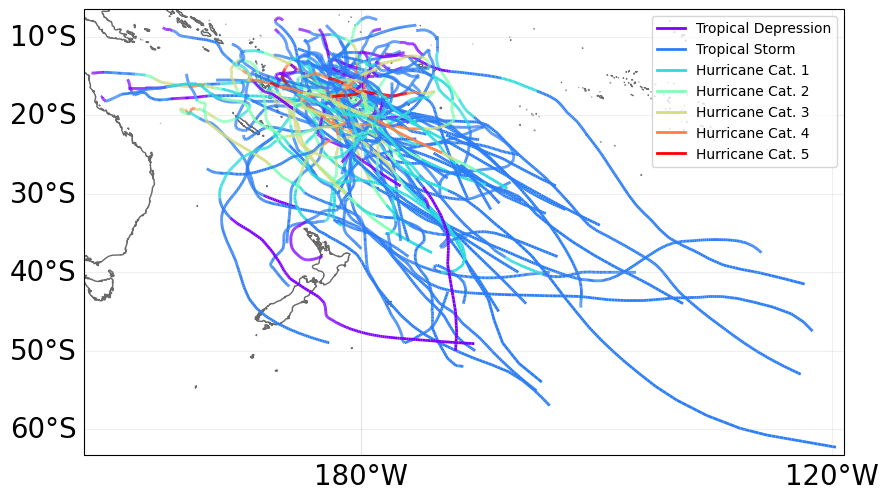

In [50]:
# Plot the tracks
# Takes a while, especially after the interpolation.
tc_tracks.plot()

## Construct the windfield

The typhoon tracks will be used to construct the wind field.
The wind field grid will be set using a geopackage file that is
used for all other grid-based data.

In [13]:
# input_dir = (Path(os.getenv("STORM_DATA_DIR"))/ "analysis/02_new_model_input/input")
# filepath = input_dir / "phl_0.1_degree_grid_centroids.gpkg"
# gdf = gpd.read_file(filepath)

filepath = (
    input_dir
    / "02_housing_damage/output/fji_0.1_degree_grid_centroids_land_overlap.gpkg"
)
gdf = gpd.read_file(filepath)
gdf["id"] = gdf["id"].astype(int)

gdf.to_crs(epsg=4326)

,id,Longitude,Latitude,Centroid,geometry
0,47,176.93806,-17.091454,176.94E_-17.09N,POINT (176.93806 -17.09145)
1,48,176.93806,-17.191454,176.94E_-17.19N,POINT (176.93806 -17.19145)
2,88,177.03806,-12.491454,177.04E_-12.49N,POINT (177.03806 -12.49145)
3,139,177.03806,-17.591454,177.04E_-17.59N,POINT (177.03806 -17.59145)
4,175,177.13806,-12.491454,177.14E_-12.49N,POINT (177.13806 -12.49145)
...,...,...,...,...,...
375,4069,181.53806,-19.091454,181.54E_-19.09N,POINT (-178.46194 -19.09145)
376,4070,181.53806,-19.191454,181.54E_-19.19N,POINT (-178.46194 -19.19145)
377,4156,181.63806,-19.091454,181.64E_-19.09N,POINT (-178.36194 -19.09145)
378,4157,181.63806,-19.191454,181.64E_-19.19N,POINT (-178.36194 -19.19145)


<GeoAxes: >

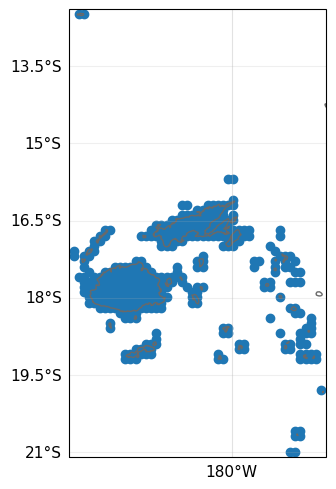

In [14]:
# multipolygon data to centroids

cent = Centroids.from_geodataframe(gdf.to_crs(epsg=4326))

cent.check()
cent.plot(figsize=(5, 5))

In [15]:
cent.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# Consider wind speeds lower than 17.5, which is the
# division between a TD and a TS.
tc = TropCyclone.from_tracks(
    tc_tracks, centroids=cent, store_windfields=True, intensity_thres=0
)

<GeoAxes: title={'center': 'Event ID 75: 2020346S13168'}>

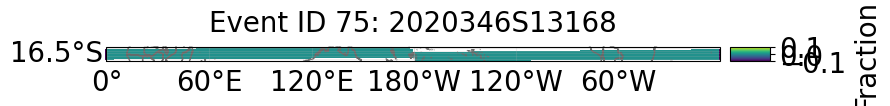

In [55]:
tc.plot_fraction(YASA_ID)

<GeoAxes: title={'center': 'Event ID 2: 2020346S13168'}>

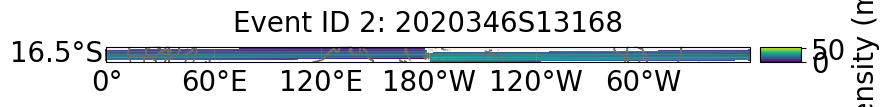

In [130]:
# Let's look at a specific typhoon as an example.
# It looks weird but I think it's just a
# projection issue, as the parts on land look fine

tc.plot_intensity(YASA_ID)

## Save the windfields

Need to extract the windfield per typhoon, and
save it in a dataframe along with the grid points

In [180]:
df_windfield = pd.DataFrame()
typhoon_metadata = pd.DataFrame()

# at this latitude grid spacing is roughly 11.6 km
GRID_SPACING = 12

for intensity_sparse, event_id in zip(tc.intensity, tc.event_name):
    # Get the windfield
    windfield = intensity_sparse.toarray().flatten()
    npoints = len(windfield)
    typhoon_info = typhoons_df[typhoons_df["typhoon_id"] == event_id]
    # Get the track distance
    tc_track = tc_tracks.get_track(track_name=event_id)
    tc_track = tc_track.sortby("time")
    # some tracks are defined with negative longitude (i.e. around -180)
    # this messes up distance calc, so correct them first here
    if tc_track.lon[0] < 0:
        tc_track["lon"] += 360
    tc_track_line = LineString(gpd.points_from_xy(tc_track.lon, tc_track.lat))
    tc_track_points = gpd.points_from_xy(tc_track.lon, tc_track.lat)
    tc_track_line = gpd.GeoDataFrame(geometry=[tc_track_line])
    # shift tracks into EPSG 3832 to calculate distance
    tc_track_line = tc_track_line.set_crs(FJI_CRS).to_crs(3832)
    tc_track_distance = (
        gdf["geometry"]
        .to_crs(3832)
        .apply(
            lambda point: point.distance(tc_track_line.iloc[0].geometry) / 1000
        )
    )
    name = typhoon_info["typhoon_name"].values[0]
    year = typhoon_info["typhoon_year"].values[0]
    nameyear = name.lower() + str(year)

    # Add to DF
    df_to_add = pd.DataFrame(
        dict(
            typhoon_id=[event_id] * npoints,
            typhoon_name=[name] * npoints,
            typhoon_year=[year] * npoints,
            grid_point_id=gdf["id"],
            wind_speed=windfield,
            track_distance=tc_track_distance,
        )
    )
    df_windfield = pd.concat([df_windfield, df_to_add], ignore_index=True)

    # determine landfall (or closest pass)

    tc_track_points = gpd.GeoDataFrame(geometry=tc_track_points)
    tc_track_points = tc_track_points.set_crs(FJI_CRS).to_crs(3832)
    df_distance = gdf.geometry.to_crs(3832).apply(
        lambda point: point.distance(tc_track_points.geometry) / 1000
    )
    tc_track_points["time"] = tc_track.time
    tc_track_points["distance_to_land"] = df_distance.min()

    # check to see if cyclone makes landfall (i.e. is within grid spacing)
    min_distance = tc_track_points["distance_to_land"].min()
    if min_distance < GRID_SPACING:
        # if makes landfall, use first date
        landfalldatetime = tc_track_points[
            tc_track_points["distance_to_land"] < GRID_SPACING
        ].iloc[0]["time"]
    else:
        # otherwise, just take minimum distance date
        landfalldatetime = tc_track_points[
            tc_track_points["distance_to_land"] == min_distance
        ].iloc[0]["time"]
    landfalldate = landfalldatetime.strftime("%d/%m/%Y")
    landfalltime = landfalldatetime.strftime("%H:%M:%S")
    startdate = tc_track_points["time"].min().strftime("%d/%m/%Y")
    enddate = tc_track_points["time"].max().strftime("%d/%m/%Y")

    df_add = pd.DataFrame(
        {
            "typhoon": nameyear,
            "startdate": startdate,
            "enddate": enddate,
            "landfalldate": landfalldate,
            "landfall_time": landfalltime,
        },
        index=[0],
    )

    typhoon_metadata = pd.concat([typhoon_metadata, df_add], ignore_index=True)


typhoon_metadata

,typhoon,startdate,enddate,landfalldate,landfall_time
0,bebe1972,19/10/1972,26/10/1972,22/10/1972,20:30:00
1,bebe1972,27/10/1972,28/10/1972,27/10/1972,00:00:00
2,juliette1973,03/04/1973,04/04/1973,03/04/1973,12:30:00
3,juliette1973,02/04/1973,03/04/1973,03/04/1973,00:00:00
4,juliette1973,05/04/1973,06/04/1973,05/04/1973,00:00:00
...,...,...,...,...,...
72,tino2020,16/01/2020,19/01/2020,17/01/2020,05:30:00
73,harold2020,01/04/2020,10/04/2020,08/04/2020,00:30:00
74,yasa2020,13/12/2020,20/12/2020,17/12/2020,06:00:00
75,bina2021,31/01/2021,31/01/2021,31/01/2021,13:30:00


In [170]:
cutoff_distance = 12

dfa = df_windfield.groupby(["typhoon_name", "typhoon_id"])[
    "track_distance"
].min()
display(dfa[dfa > cutoff_distance])

typhoon_name  typhoon_id   
Arthur        2007021S12183     516.848320
Atu           2011048S14171     628.811449
Bebe          1972301S25189     997.532489
Bina          2021029S14162     254.108633
Bob           1977365S09188     936.092718
              1978032S09187      18.697833
Bola          1988055S10180     144.327153
Bune          2011082S17184      13.116910
Cyril         1984076S13173     127.776691
Dani          1999013S13164    1013.852114
Daphne        2012092S16166     458.847131
Eric          1985019S23191    1058.744795
Eseta         1988352S14166     476.004914
Gavin         1985062S15170     331.724867
Gita          2018038S15172      24.699450
Harry         1989037S16164    1252.235442
Hettie        1982024S18166     185.260161
Hina          1985070S17175      42.605575
Ian           1997105S10168     123.408760
Jim           2006025S18147     957.965890
Joni          1992338S04173     869.384960
Josie         2018089S18172     101.189873
Juliette      1973092S1517

<Axes: xlabel='typhoon_year', ylabel='track_distance'>

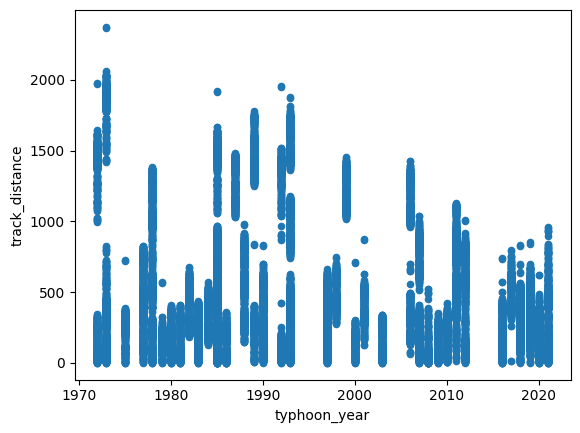

In [52]:
df_windfield.plot.scatter("typhoon_year", "track_distance")

## Sanity checks

<Axes: >

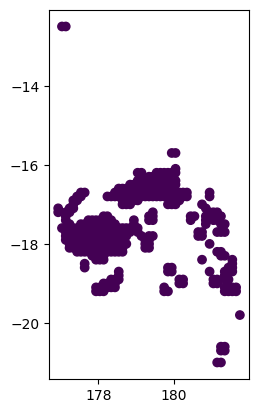

In [104]:
# Check that that the grid points match for the example typhoon.
# Looks good to me!
df_example = df_windfield[df_windfield["typhoon_id"] == "1972301S25189"]
gdf_example = gdf.merge(df_example, left_on="id", right_on="grid_point_id")
gdf_example.plot(c=gdf_example["wind_speed"])

<Axes: xlabel='track_distance', ylabel='wind_speed'>

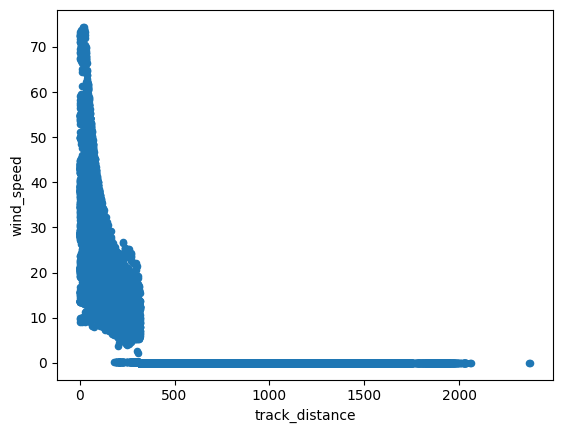

In [51]:
# Plot wind speed against track distance
df_windfield.plot.scatter("track_distance", "wind_speed")

## Save everything

In [106]:
# Save df as a csv file
df_windfield.to_csv(input_dir / "01_windfield/windfield_data.csv")

In [178]:
typhoons_df.to_csv(input_dir / "01_windfield/typhoons.csv")

In [183]:
typhoon_metadata.to_csv(
    input_dir / "03_rainfall/input/metadata_typhoons.csv", index=False
)